# Using MCMC to Estimate Parameters in a Regime-Switching Gaussian Mixture Model


# Generate Simulated Returns Data

First we will generate some simulated returns data, which we will seek to sample from using MCMC.

We will simulate a time series that alternates between two regimes:
- Regime 0 (Bear Market): Lower mean return, higher volatility.
- Regime 1 (Bull Market): Higher mean return, lower volatility.

The regime switches are deliberately kept subtle to help the returns data look realistic. The regime changes can be seen more easily by trying out larger values for the means.

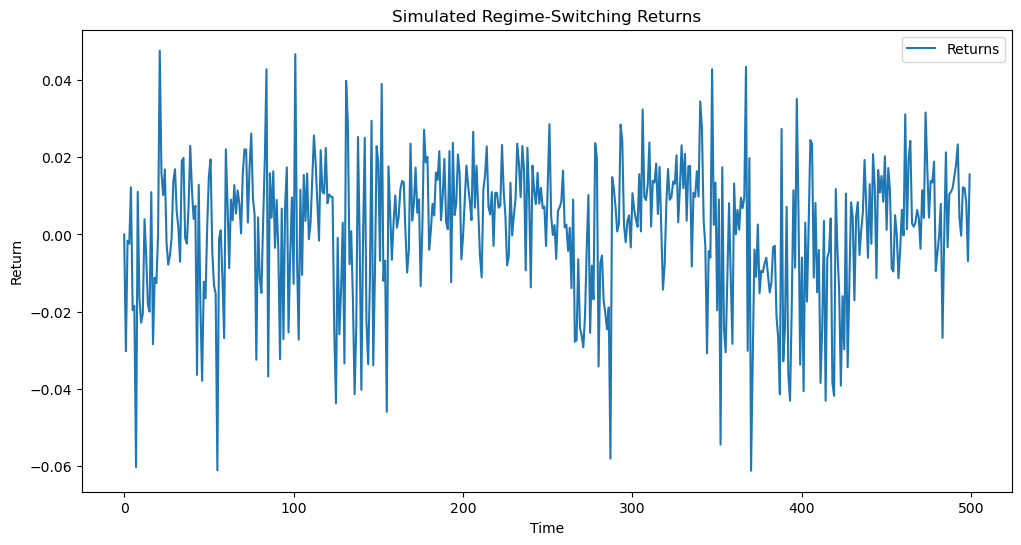

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
n_samples = 500
transition_matrix = np.array([[0.95, 0.05],  # From Regime 0 to 0 | 1
                              [0.05, 0.95]]) # From Regime 1 to 0 | 1

# Means for Regime 0 and 1
means = [-0.008, 0.008]  
# Std devs for Regime 0 and 1 
std_devs = [0.02, 0.01]  

# Initialize arrays
states = np.zeros(n_samples, dtype=int)
returns = np.zeros(n_samples)

# Simulate states and returns
for t in range(1, n_samples):
    states[t] = np.random.choice([0, 1], p=transition_matrix[states[t-1]])
    returns[t] = np.random.normal(means[states[t]], std_devs[states[t]])

# Create DataFrame
data = pd.DataFrame({'Return': returns, 'State': states})

# Plot simulated returns
plt.figure(figsize=(12, 6))
plt.plot(data['Return'], label='Returns')
plt.title('Simulated Regime-Switching Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()


# Perform MCMC

In the following cell, we define prior distributions for the parameters and update them with data to obtain posterior distributions.

A Gaussian Mixture Model (GMM) is used as an approximation, which considers the data as coming from multiple distributions without accounting for the sequential dependency. The parameters for a GMM are mixture weights, means and standard deviations.

In [9]:
import pymc as pm

# Define the model
with pm.Model() as model:
    # Priors for the mixture weights
    weights = pm.Dirichlet('weights', a=np.array([1, 1]))
    
    # Priors for the means and standard deviations
    mus = pm.Normal('mus', mu=0, sigma=0.01, shape=2)
    sigmas = pm.HalfNormal('sigmas', sigma=0.01, shape=2)
    
    # Define the mixture distribution
    mix = pm.Normal.dist(mu=mus, sigma=sigmas)
    returns_obs = pm.Mixture('returns_obs', w=weights, comp_dists=mix, observed=data['Return'])
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mus, sigmas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


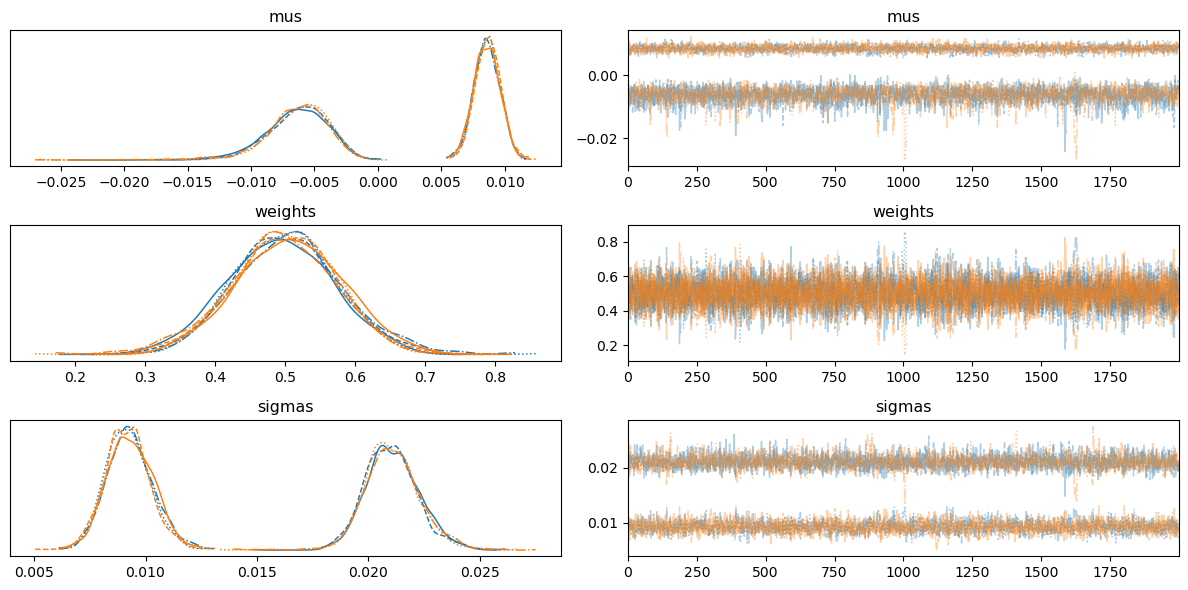

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mus[0]      0.001  0.008  -0.010    0.011      0.004    0.003       6.0   
mus[1]      0.001  0.008  -0.009    0.011      0.004    0.003       6.0   
weights[0]  0.500  0.078   0.352    0.642      0.002    0.001    2657.0   
weights[1]  0.500  0.078   0.358    0.648      0.002    0.001    2657.0   
sigmas[0]   0.015  0.006   0.008    0.023      0.003    0.002       6.0   
sigmas[1]   0.015  0.006   0.008    0.023      0.003    0.002       6.0   

            ess_tail  r_hat  
mus[0]         132.0   1.73  
mus[1]         126.0   1.74  
weights[0]    2610.0   1.00  
weights[1]    2610.0   1.00  
sigmas[0]      131.0   1.73  
sigmas[1]      116.0   1.74  


In [11]:
# Trace plots
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

# Summary statistics
summary = pm.summary(trace)
print(summary)


# Interpretation of the Trace Plot

1. The means (mus) are represented accurately by the MCMC, with distributions peaked around `+0.08` and `-0.08`, as was defined when initializing the timeseries.
2. The weights are both centered at around `0.5`, which makes sense since the transition matrix represents equal probability of being in bullish regime or a bearish regime.
3. The distributions for the standard deviation are close to 0.1 and 0.2, which also matches the values used to generate the simulated returns.